In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import seaborn as sns

In [2]:
censo_url  = 'https://raw.githubusercontent.com/guillermodangelo/tesis/master/tablas/personas_censo_2011.zip'

metadatos_figs = {'Author': '''Guillermo D'Angelo''', 'Title': 'Pirámide de población Censo INE 2011'}

In [3]:
# Datos censales
censo = pd.read_csv(censo_url, compression='zip', header=0, sep=',', quotechar='"')

# genera etiquetas con los tramos de edad usuales
labels = ['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49',
          '50-54','55-59','60-64','65-69','70-74','75-79','80-84','85-89','90-94']

# genera lista con cortes, para reclasificar el dataframe
bins = [0,4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,89,94]

# calcula tramos de edad
censo['tramo'] =   pd.cut(censo['PERNA01'], bins= bins, include_lowest=False,  labels= labels)
censo['tramo'] = np.where(censo['PERNA01'] > 94 ,'95+', censo['tramo'])


# define vector de nombres de columnas para filtrar
cols = ['DPTO', 'LOC', 'SECC', 'SEGM', 'PERPH02', 'PERNA01', 'PERMI07',
        'PERMI07_1', 'PERMI07_2', 'PERMI07_3', 'PERMI07_4', 'tramo']

# filtra
p_migr = censo[(censo.PERMI07 == 2) | (censo.PERMI07 == 3)][cols]

p_migr.head()

,DPTO,LOC,SECC,SEGM,PERPH02,PERNA01,PERMI07,PERMI07_1,PERMI07_2,PERMI07_3,PERMI07_4,tramo
5,1,20,1,1,1,24,3,NaN,3.0,732.0,0,20-24
40,1,20,1,1,2,22,3,NaN,17.0,220.0,0,20-24
50,1,20,1,1,1,19,3,NaN,18.0,220.0,0,15-19
64,1,20,1,1,1,24,3,NaN,2.0,220.0,0,20-24
110,1,20,1,1,2,28,3,NaN,12.0,320.0,0,25-29


In [4]:
# define función para agrupar por tramos y edad
def agrupar_df(df, col_tramo, col_sexo):
    # agrupa
    df_group = df.groupby([col_sexo, col_tramo]).size().reset_index()
    # renombra vars
    df_group.rename(columns={col_sexo: 'sexo', 0:'personas'}, inplace=True)
    # calcula porcentajes
    df_group['porc_pers'] = (df_group.personas / df_group.personas.sum())*100
    # pasa varones a negativo para hacer bien la gráfica
    df_group['personas'] = np.where(df_group['sexo'] ==1, -df_group['personas'], df_group['personas'])
    df_group['porc_pers'] = np.where(df_group['sexo'] ==1, -df_group['porc_pers'], df_group['porc_pers'])
    # genera etiqueta del sexo
    df_group['sexo_label'] = np.where(df_group['sexo'] ==1, 'varones', 'mujeres')
    return df_group

In [5]:
# agrupa migrantes recientes
migrantes_group = agrupar_df(p_migr,'tramo', 'PERPH02')

# con todo el censo
censo_group = agrupar_df(censo,'tramo', 'PERPH02')

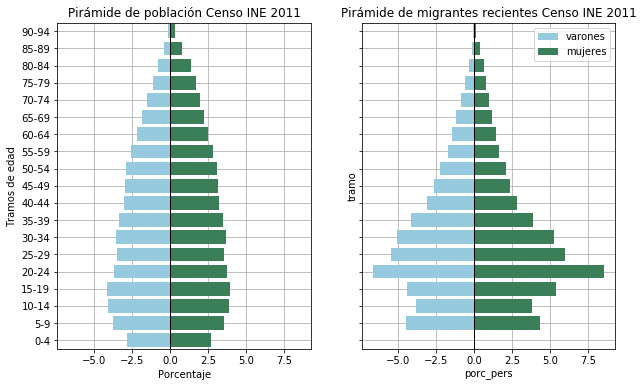

In [27]:
# pirámides de población

# cuatro ejes
fig, (ax1, ax2)  = plt.subplots(1,2, figsize= ( 10, 6 ), sharex= True, sharey='row')

# plot
group_col = 'sexo_label'
order_of_bars = labels[::-1]
colors = ['skyblue', 'seagreen']
label=['sexo', 'sasa']

for c, group in zip(colors, censo_group[group_col].unique()):
    sns.barplot(x='porc_pers', y='tramo', data=censo_group.loc[censo_group[group_col]==group, :],
                order = order_of_bars, color=c, label=group, ax=ax1)

for c, group in zip(colors, migrantes_group[group_col].unique()):
    sns.barplot(x='porc_pers', y='tramo', data=migrantes_group.loc[migrantes_group[group_col]==group, :],
                order = order_of_bars, color=c, label=group, ax=ax2)

ax1.set_title('Pirámide de población Censo INE 2011')
ax2.set_title('Pirámide de migrantes recientes Censo INE 2011')

for i in [ax1, ax2]:
    i.set_axisbelow(True)
    i.set_ylabel("Tramos de edad")
    i.set_xlabel("Porcentaje")
    i.grid(True)
    i.axvline(linewidth=1, color='black')

# chirimbolos
plt.legend(loc='upper right')
plt.show()

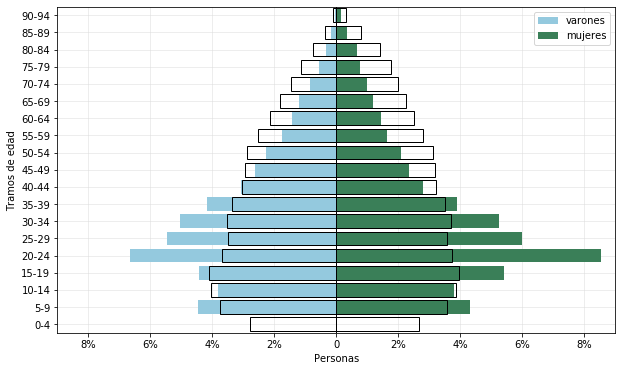

In [7]:
# pirámides de población solapadas
fig, ax  = plt.subplots(1, figsize= ( 10, 6 ))

# plot
group_col = 'sexo_label'
order_of_bars = labels[::-1]
colors = ['skyblue', 'seagreen']
label=['sexo', 'sasa']


for c, group in zip(colors, migrantes_group[group_col].unique()):
    sns.barplot(x='porc_pers', y='tramo',
                data=migrantes_group.loc[migrantes_group[group_col]==group, :],
                order = order_of_bars,
                color=c,
                label=group,
                ax=ax)

    sns.barplot(x='porc_pers', y='tramo',
                data=censo_group.loc[censo_group[group_col]==group, :],
                order = order_of_bars,
                fill=False,
                linewidth = 1,
                edgecolor='black',
                ax=ax)

ax.set_axisbelow(True)
ax.grid(color='gainsboro', linestyle='-', linewidth=0.5)
ax.set_ylabel("Tramos de edad")
ax.set_xlabel("Personas")
ax.axvline(linewidth=1, color='black')
ax.set_xlim([-9,9])
ax.set_xticklabels(['10%','8%','6%','4%','2%','0','2%','4%','6%','8%'])

# chirimbolos
plt.legend(loc='upper right')

plt.savefig('mapas_graficas/piramide_mig.pdf', bbox_inches='tight',
            metadata = metadatos_figs )

In [8]:
# migrantes recientes a Mvdeo. vs migrantes recientes a otros lados  
mvo = p_migr[p_migr.DPTO==1]
int_no_mvo = p_migr[ (p_migr.DPTO != 1) & (p_migr.PERMI07_2 != 1.0) ]
int_si_mvo = p_migr[ (p_migr.DPTO!=1) & (p_migr.PERMI07_2 == 1.0) ]

mvo_group = agrupar_df( mvo,'tramo', 'PERPH02')
int_no_mvo_group = agrupar_df( int_no_mvo,'tramo', 'PERPH02')
int_si_mvo_group = agrupar_df( int_si_mvo,'tramo', 'PERPH02')

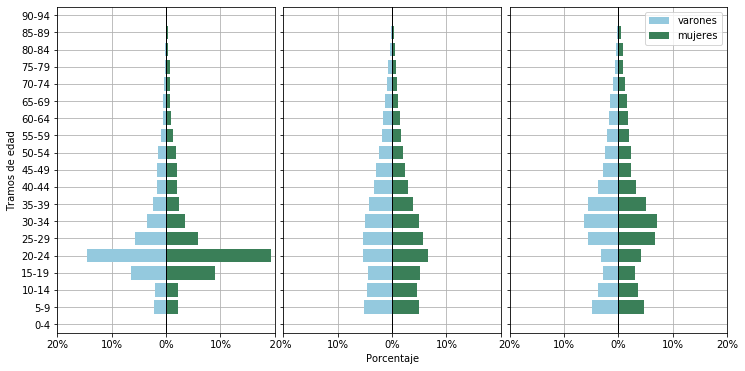

In [39]:
# pirámides de población

# cuatro ejes
fig, (ax1, ax2, ax3)  = plt.subplots(1,3, figsize= ( 12, 6 ), sharex= False, sharey='row')

plt.subplots_adjust( wspace=0.04)


# plot
group_col = 'sexo_label'
order_of_bars = labels[::-1]
colors = ['skyblue', 'seagreen']
label=['sexo', 'sasa']

for c, group in zip(colors, mvo_group[group_col].unique()):
    sns.barplot(x='porc_pers', y='tramo', data=mvo_group.loc[mvo_group[group_col]==group, :],
                order = order_of_bars, color=c, label=group, ax=ax1)

for c, group in zip(colors, int_no_mvo_group[group_col].unique()):
    sns.barplot(x='porc_pers', y='tramo', data=int_no_mvo_group.loc[int_no_mvo_group[group_col]==group, :],
                order = order_of_bars, color=c, label=group, ax=ax2)
    
for c, group in zip(colors, int_si_mvo_group[group_col].unique()):
    sns.barplot(x='porc_pers', y='tramo', data=int_si_mvo_group.loc[int_si_mvo_group[group_col]==group, :],
                order = order_of_bars, color=c, label=group, ax=ax3)

# ax1.set_title('Migrantes a Mvdeo.')
# ax2.set_title('Migrantes entre deptos interior')
# ax3.set_title('Migrantes desde Mvdeo.')
ax1.set_ylabel("Tramos de edad")


for i in [ax1, ax2, ax3]:
    i.set_axisbelow(True)
    i.grid(True)
    i.axvline(linewidth=1, color='black')
    i.set_xlim([-20,20])

ax1.set_xlabel('')
ax2.set_xlabel("Porcentaje")
ax3.set_xlabel('')

ax1.set_xticklabels(['20%','10%','0%','10%','    20%'])
ax2.set_xticklabels(['','10%','0%','10%',''])
ax3.set_xticklabels(['20%','10%','0%','10%','20%'])

ax2.set_ylabel('')
ax3.set_ylabel('')

plt.legend(loc='upper right')
plt.savefig('mapas_graficas/piramides_mig_recientes.pdf', bbox_inches='tight',
            metadata = metadatos_figs )